In [9]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [10]:
import pandas as pd
import numpy as np

# Updated to use 2018-19 data
df_2018_19 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2018-19'", con)
columns_to_drop = [col for col in df_2018_19.columns if col.startswith("UniReqs") or col.startswith("RegHSDiploma") or col.startswith("Dropout")]

# Lasso

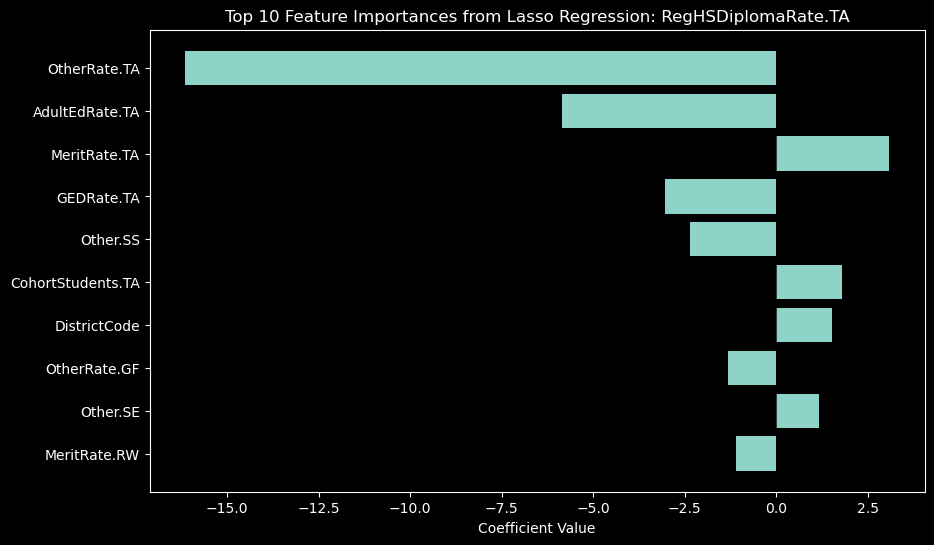

R^2 Score: -0.00030451290406929843
Mean Squared Error: 668.7708353396166
Root Mean Squared Error: 25.8606039244952


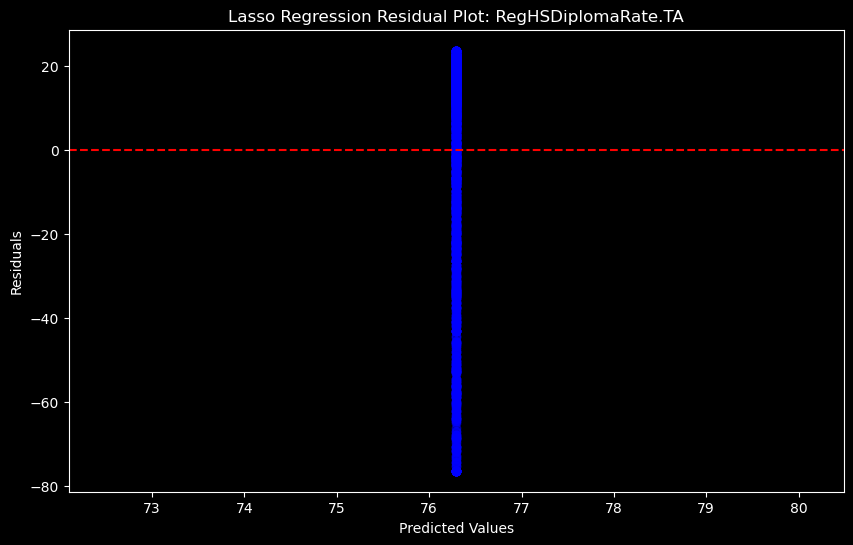

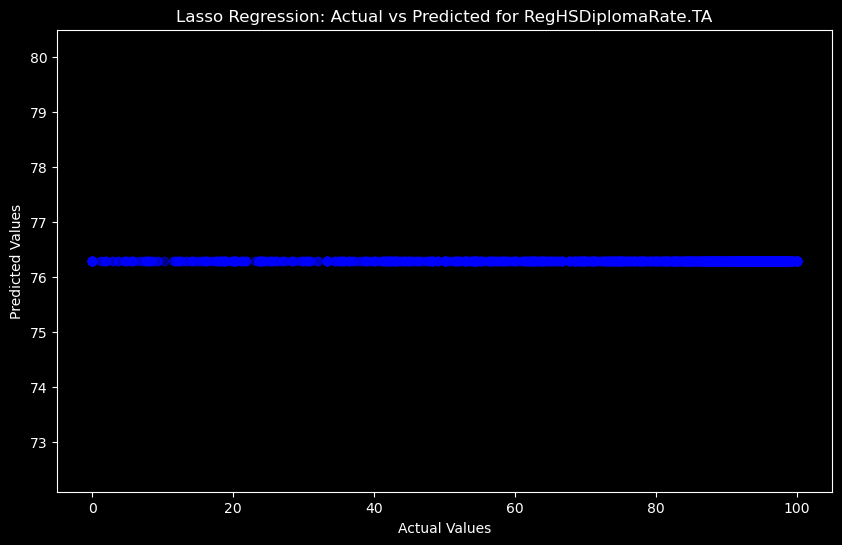

In [11]:
import modeling.utils.lasso as lasso_utils

target_column = "RegHSDiplomaRate.TA"

X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2018_19, target_column, columns_to_drop
)
lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)
print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")
lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

### CSU/UC Graduation Rate

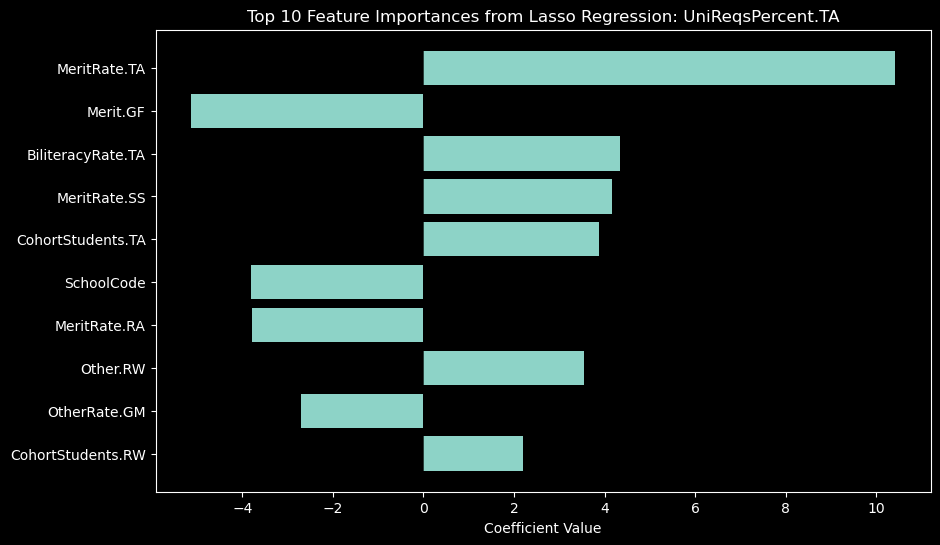

R^2 Score: 0.011883492876104906
Mean Squared Error: 1032.2757842599917
Root Mean Squared Error: 32.12904891620653


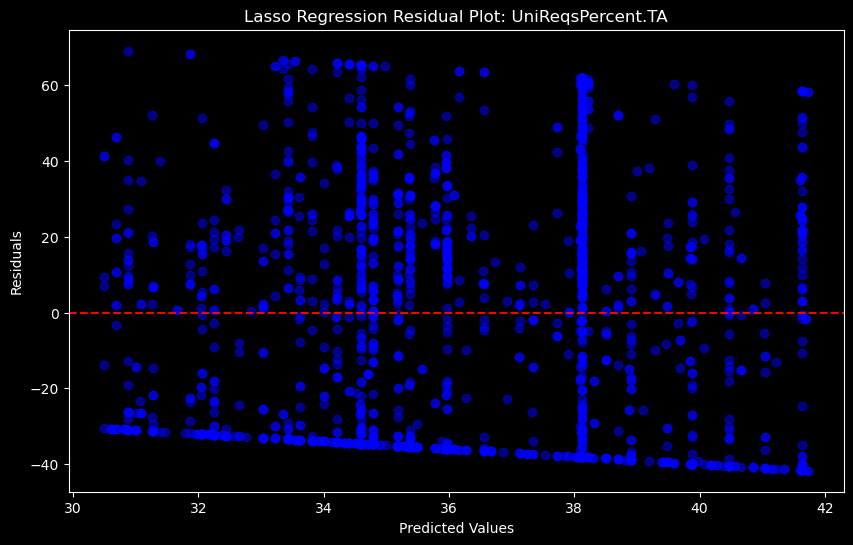

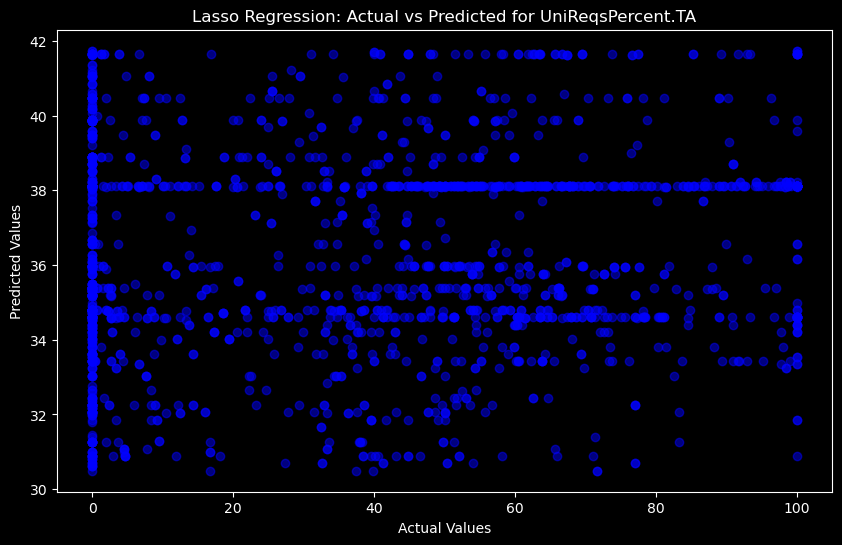

In [12]:
target_column = "UniReqsPercent.TA"


X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2018_19, target_column, columns_to_drop
)


lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)

print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")

lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

# XGBoost

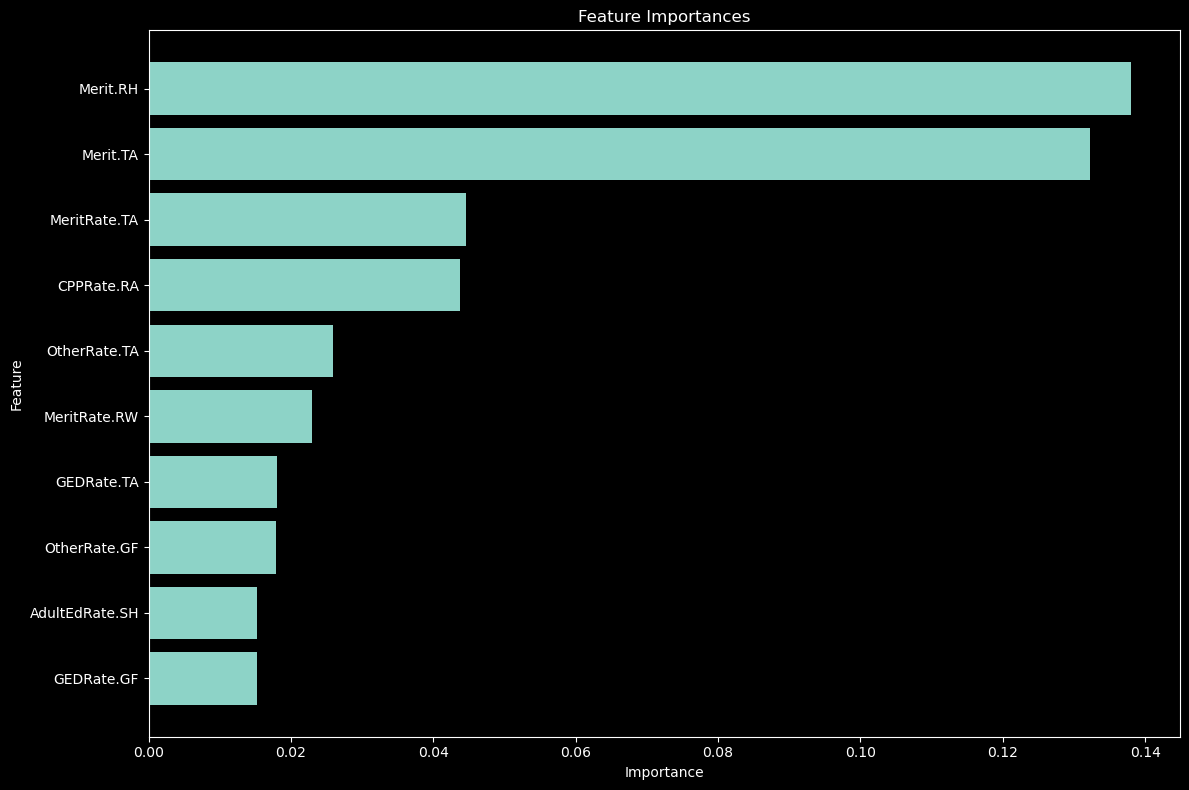

{'MSE': 70.6349309141126, 'RMSE': 8.40445898997149, 'MAE': 5.637785330914468, 'R^2': 0.9323867300967202}


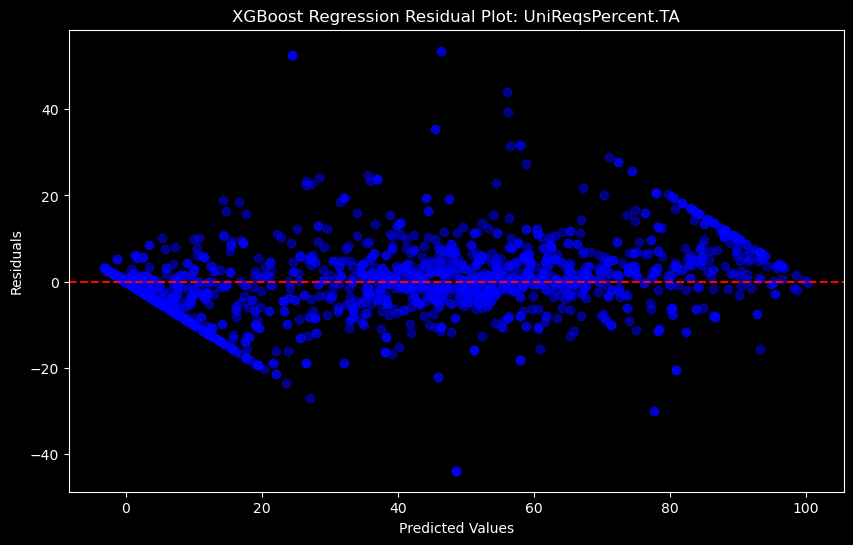

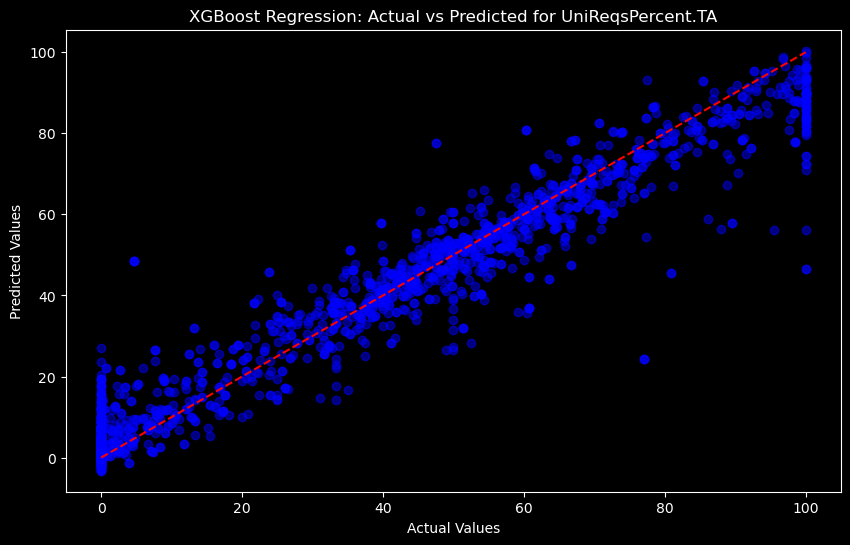

In [13]:
import modeling.utils.xgboost as xgb_utils

target_column = "UniReqsPercent.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2018_19, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

## Graduation Rate

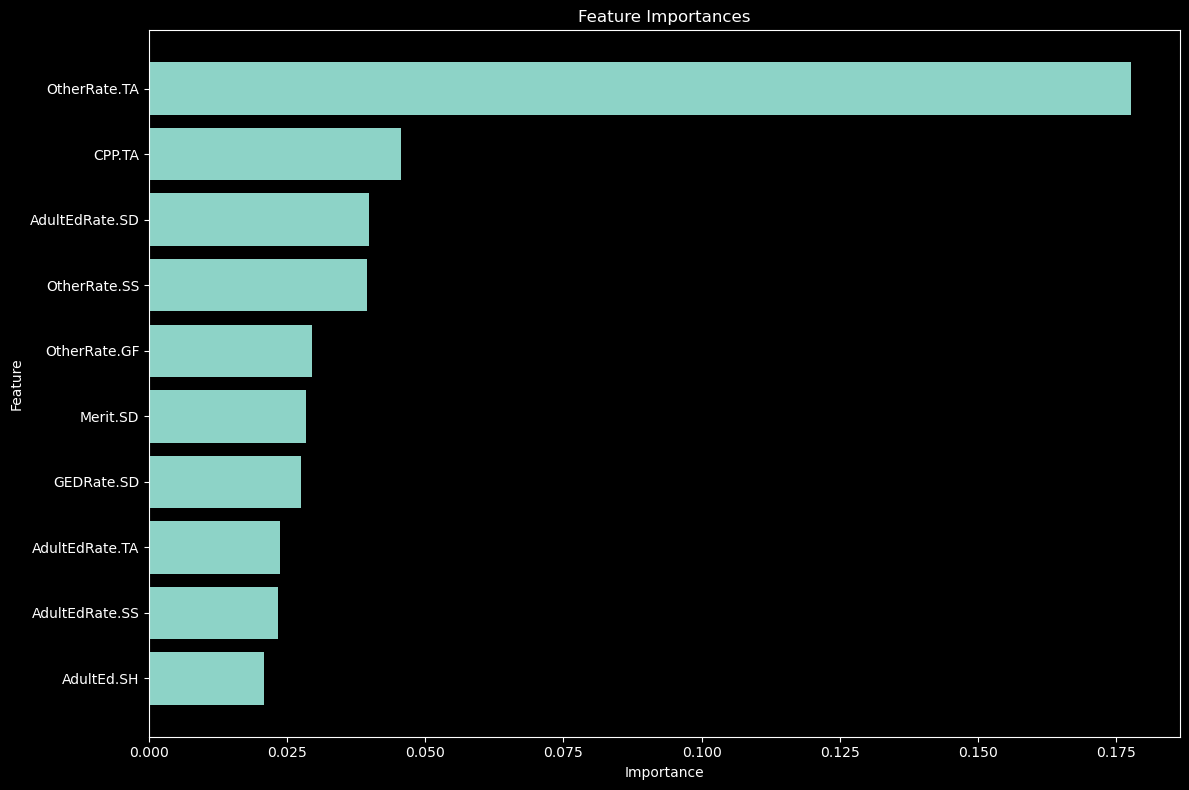

{'MSE': 12.932539195509394, 'RMSE': 3.5961839768717887, 'MAE': 2.142698657476361, 'R^2': 0.9806563375120756}


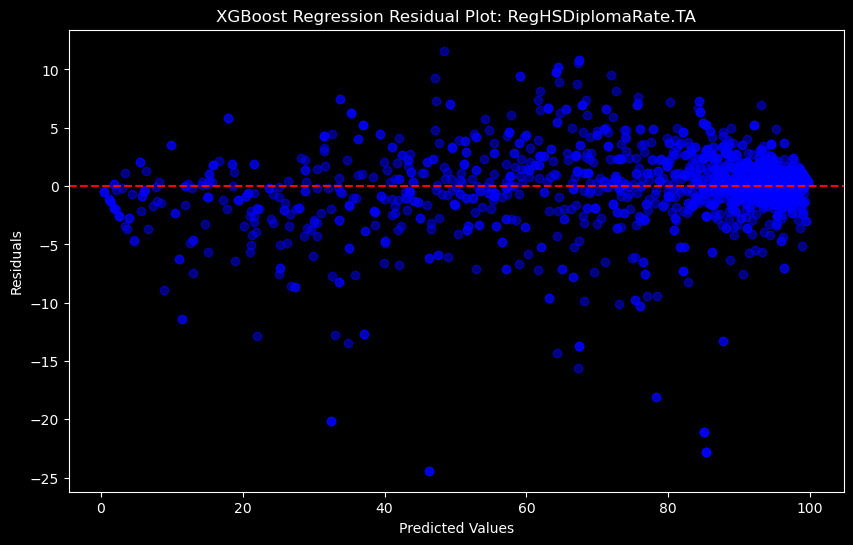

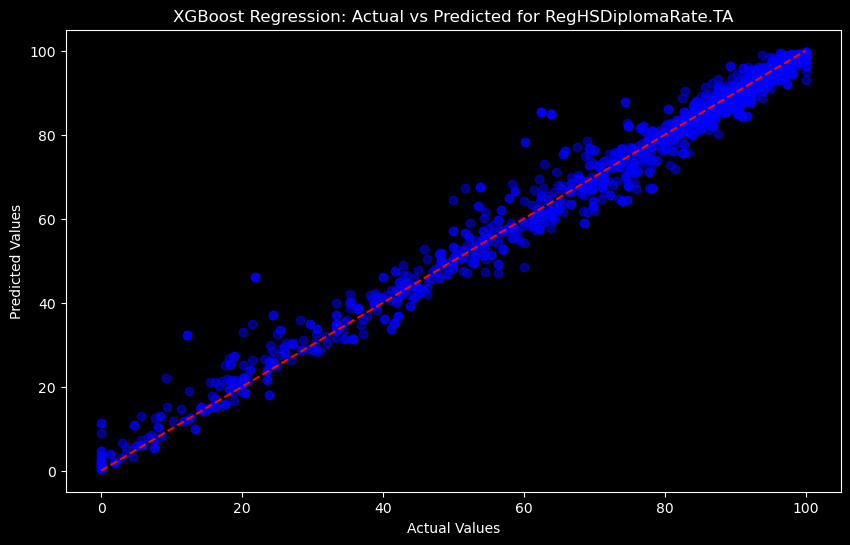

In [14]:
target_column = "RegHSDiplomaRate.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2018_19, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

# Random Forest

Predict Graduation Rate

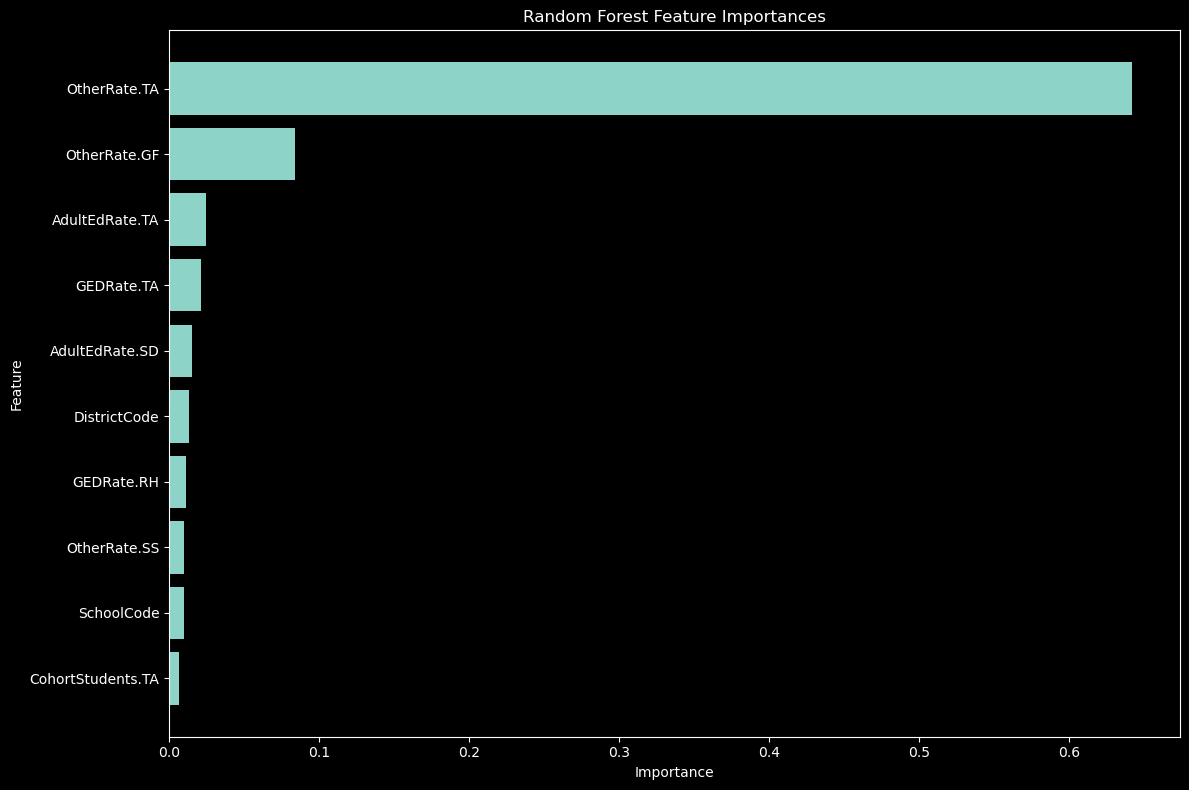

{'MSE': 2.381461811347542, 'RMSE': 1.5431985651067532, 'R²': 0.996046372557162}


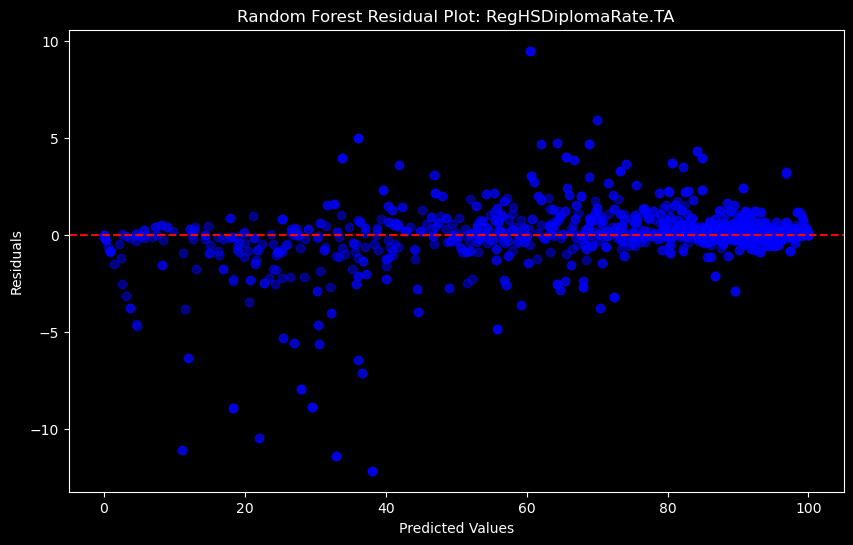

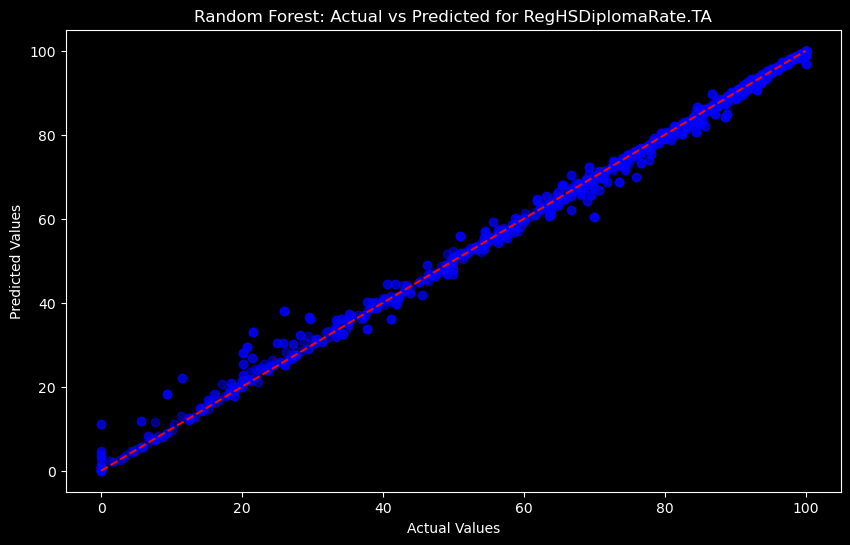

In [15]:
import modeling.utils.randomforest as rf_utils

df_2018_19_clean = df_2018_19.copy()
df_2018_19_clean = df_2018_19_clean.select_dtypes(include=[np.number])  # Keep only numeric columns
df_2018_19_clean = df_2018_19_clean.fillna(df_2018_19_clean.mean())  # Impute with mean

# Filter columns_to_drop to include only columns that exist in merged_clean
columns_to_drop_filtered = [col for col in columns_to_drop if col in df_2018_19_clean.columns]

rf_grad = rf_utils.train_random_forest_model(df_2018_19_clean, "RegHSDiplomaRate.TA", columns_to_drop_filtered)
print(rf_grad["metrics"])
rf_utils.plot_rf_residuals(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")
rf_utils.plot_rf_actual_predicted(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")

Predict CSU/UC Readiness


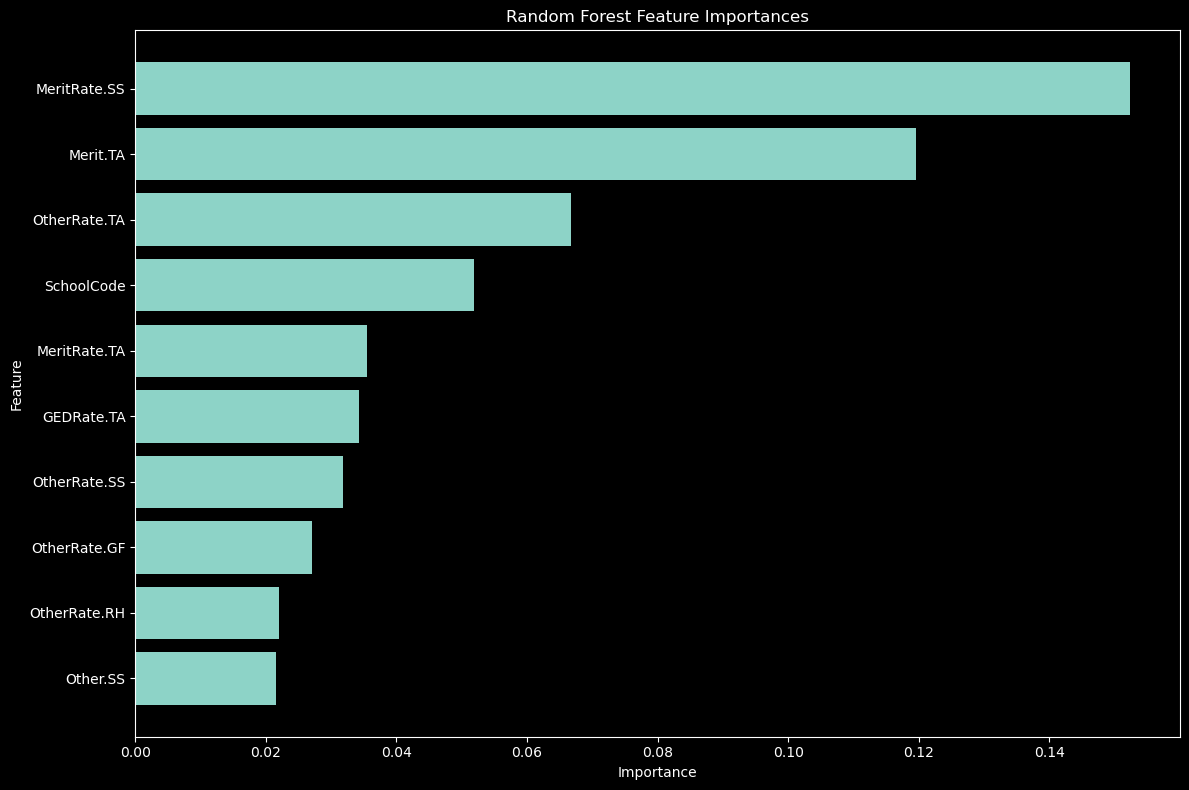

{'MSE': 7.59723515382715, 'RMSE': 2.756308247244337, 'R²': 0.9919655556849519}


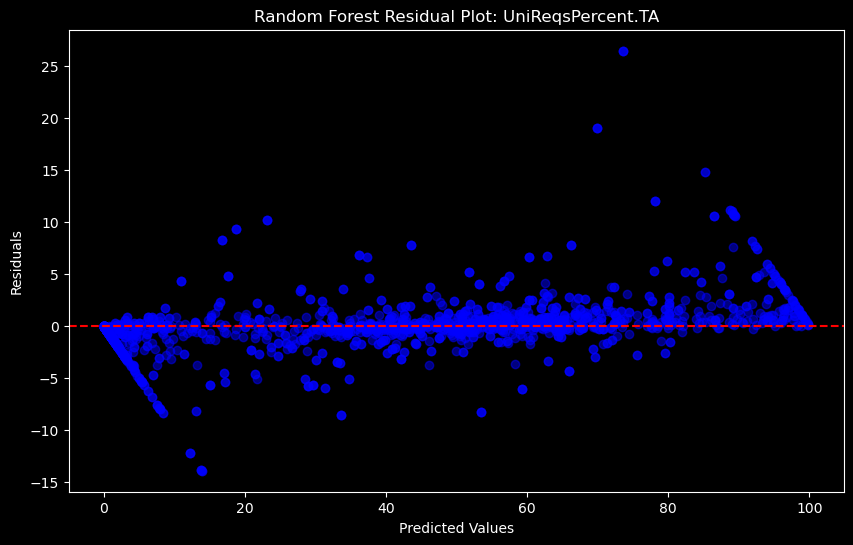

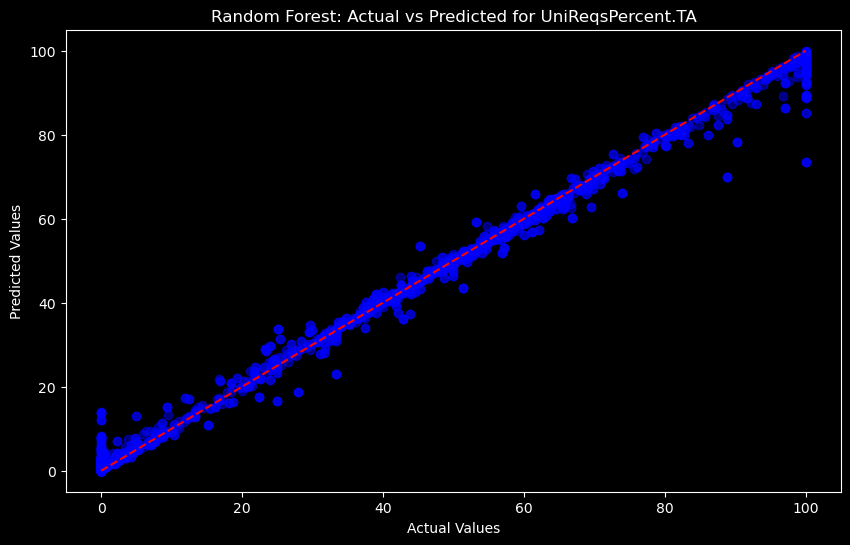

In [16]:
rf_uni = rf_utils.train_random_forest_model(df_2018_19_clean, "UniReqsPercent.TA", columns_to_drop_filtered)
print(rf_uni["metrics"])
rf_utils.plot_rf_residuals(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")
rf_utils.plot_rf_actual_predicted(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")

Predict Dropout Rate

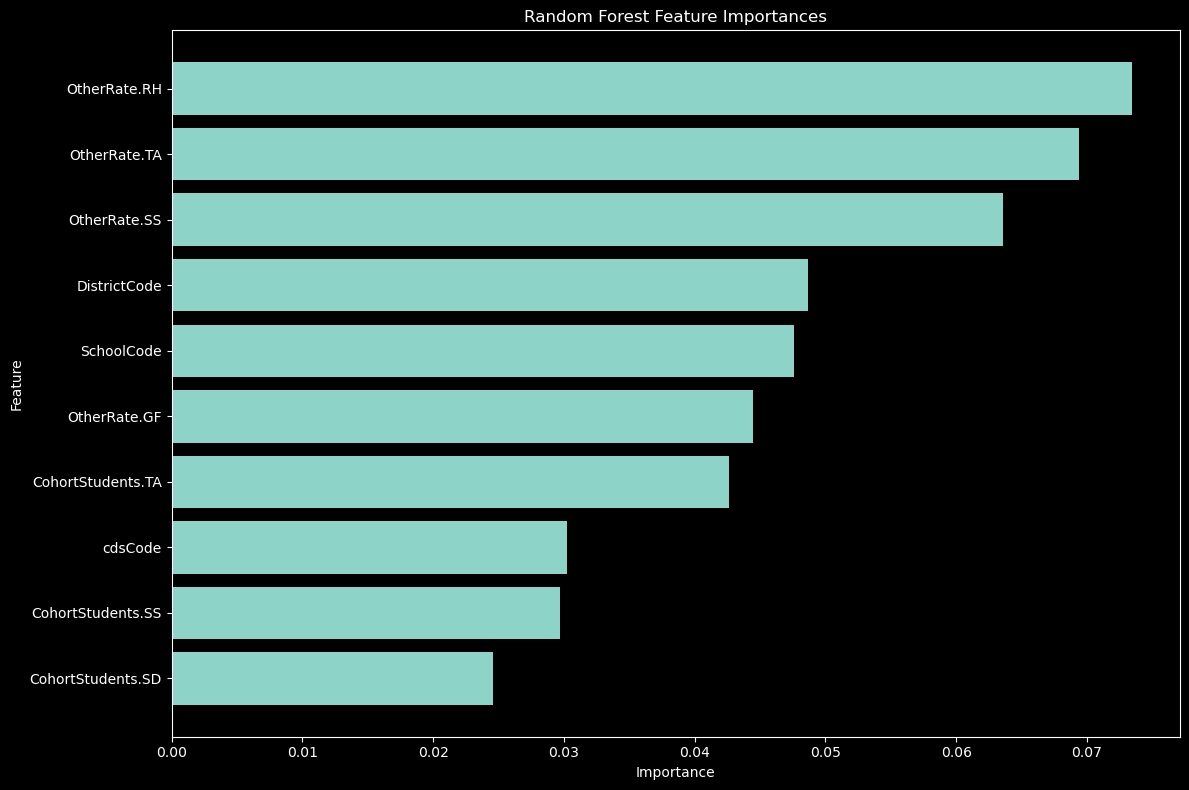

{'MSE': 2.2485863899868654, 'RMSE': 1.4995287226281682, 'R²': 0.9843454939684898}


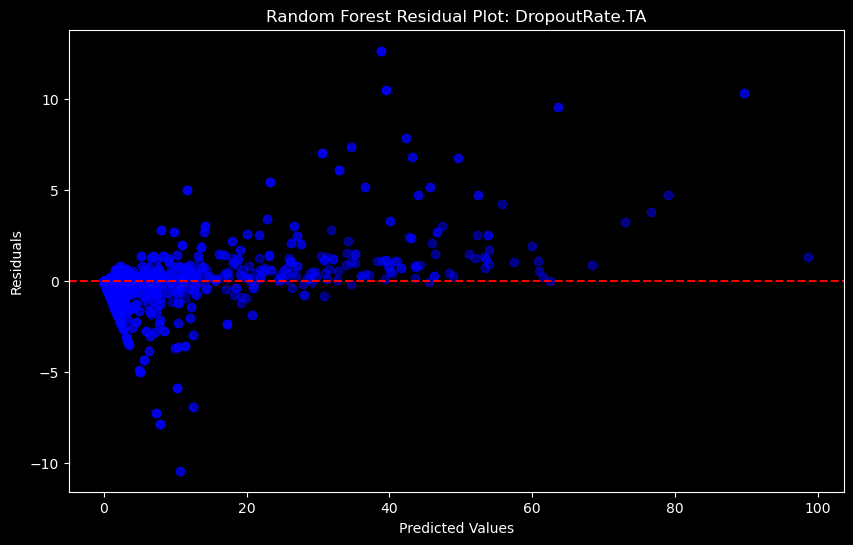

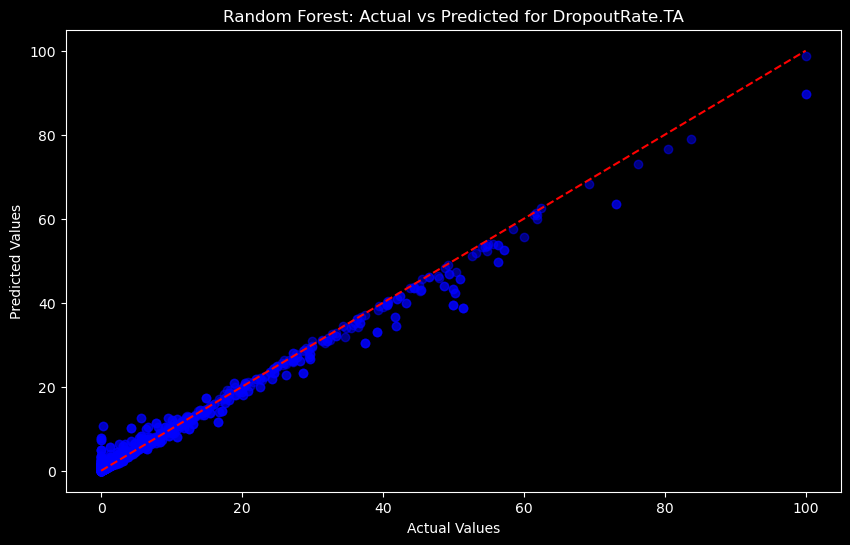

In [17]:
rf_dropout = rf_utils.train_random_forest_model(df_2018_19_clean, "DropoutRate.TA", columns_to_drop_filtered)
print(rf_dropout["metrics"])
rf_utils.plot_rf_residuals(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")
rf_utils.plot_rf_actual_predicted(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")